In [1]:
import numpy as np
import pandas as pd
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


In [3]:
df = pd.read_csv('data/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [6]:
label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [7]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

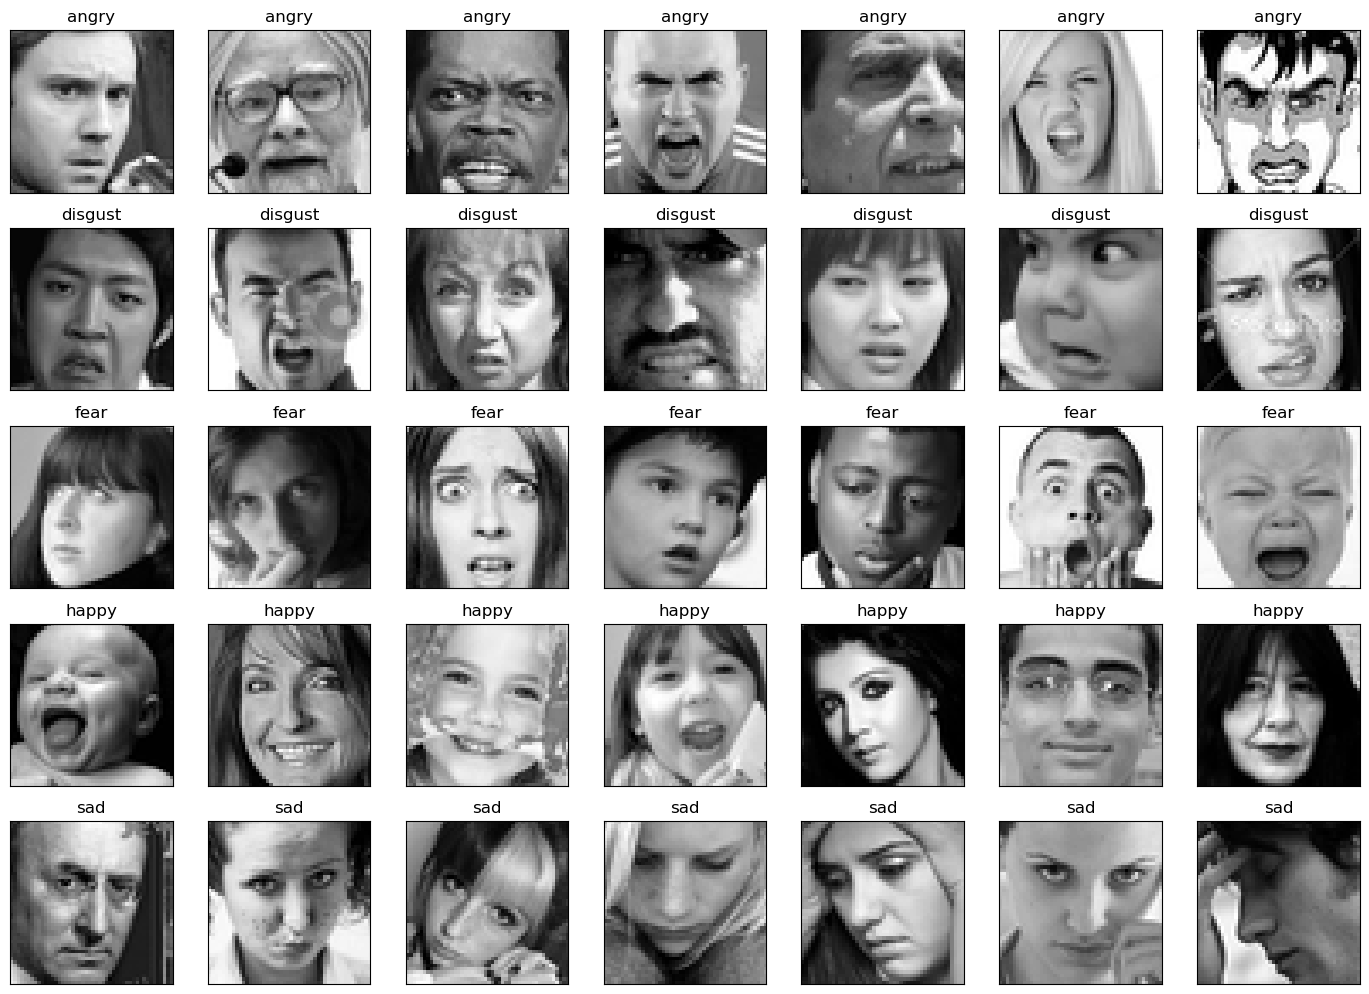

In [7]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [8]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [9]:
img_array.shape

(25687, 48, 48, 1)

In [10]:
import keras.utils
from keras.utils import to_categorical
#from keras.utils import np_utils
from keras import utils as np_utils
#from tensorflow.contrib.keras.python.keras.utils    import np_utils
import np_utils
from keras.src.utils.np_utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = keras.utils.to_categorical(img_labels)
img_labels.shape

(25687, 5)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23118, 48, 48, 1), (2569, 48, 48, 1), (23118, 5), (2569, 5))

In [12]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [13]:
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator=train_datagen.flow(X_train,y_train,batch_size=64)
validation_datagen = ImageDataGenerator(horizontal_flip=True)
validation_generator=validation_datagen.flow(X_valid,y_valid,batch_size=64)



In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(7,activation='softmax'),

])

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [15]:

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]



history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train) / 64,
    epochs=80,
    callbacks=callbacks
)

Epoch 1/80
362/361 [==============================] - ETA: 0s - loss: 1.6432 - accuracy: 0.3332
Epoch 1: saving model to model_weights.h5
361/361 [==============================] - 386s 1s/step - loss: 1.6432 - accuracy: 0.3332 - val_loss: 1.8045 - val_accuracy: 0.3499
Epoch 2/80
362/361 [==============================] - ETA: 0s - loss: 1.2736 - accuracy: 0.4620
Epoch 2: saving model to model_weights.h5
361/361 [==============================] - 300s 830ms/step - loss: 1.2736 - accuracy: 0.4620 - val_loss: 1.3399 - val_accuracy: 0.4395
Epoch 3/80
362/361 [==============================] - ETA: 0s - loss: 1.0942 - accuracy: 0.5426
Epoch 3: saving model to model_weights.h5
361/361 [==============================] - 330s 915ms/step - loss: 1.0942 - accuracy: 0.5426 - val_loss: 1.0711 - val_accuracy: 0.5496
Epoch 4/80
362/361 [==============================] - ETA: 0s - loss: 0.9998 - accuracy: 0.5872
Epoch 4: saving model to model_weights.h5
361/361 [==============================] - 370

In [16]:
model.save_weights('model_weights.h5')


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [21]:
model.save('major_project.h5')

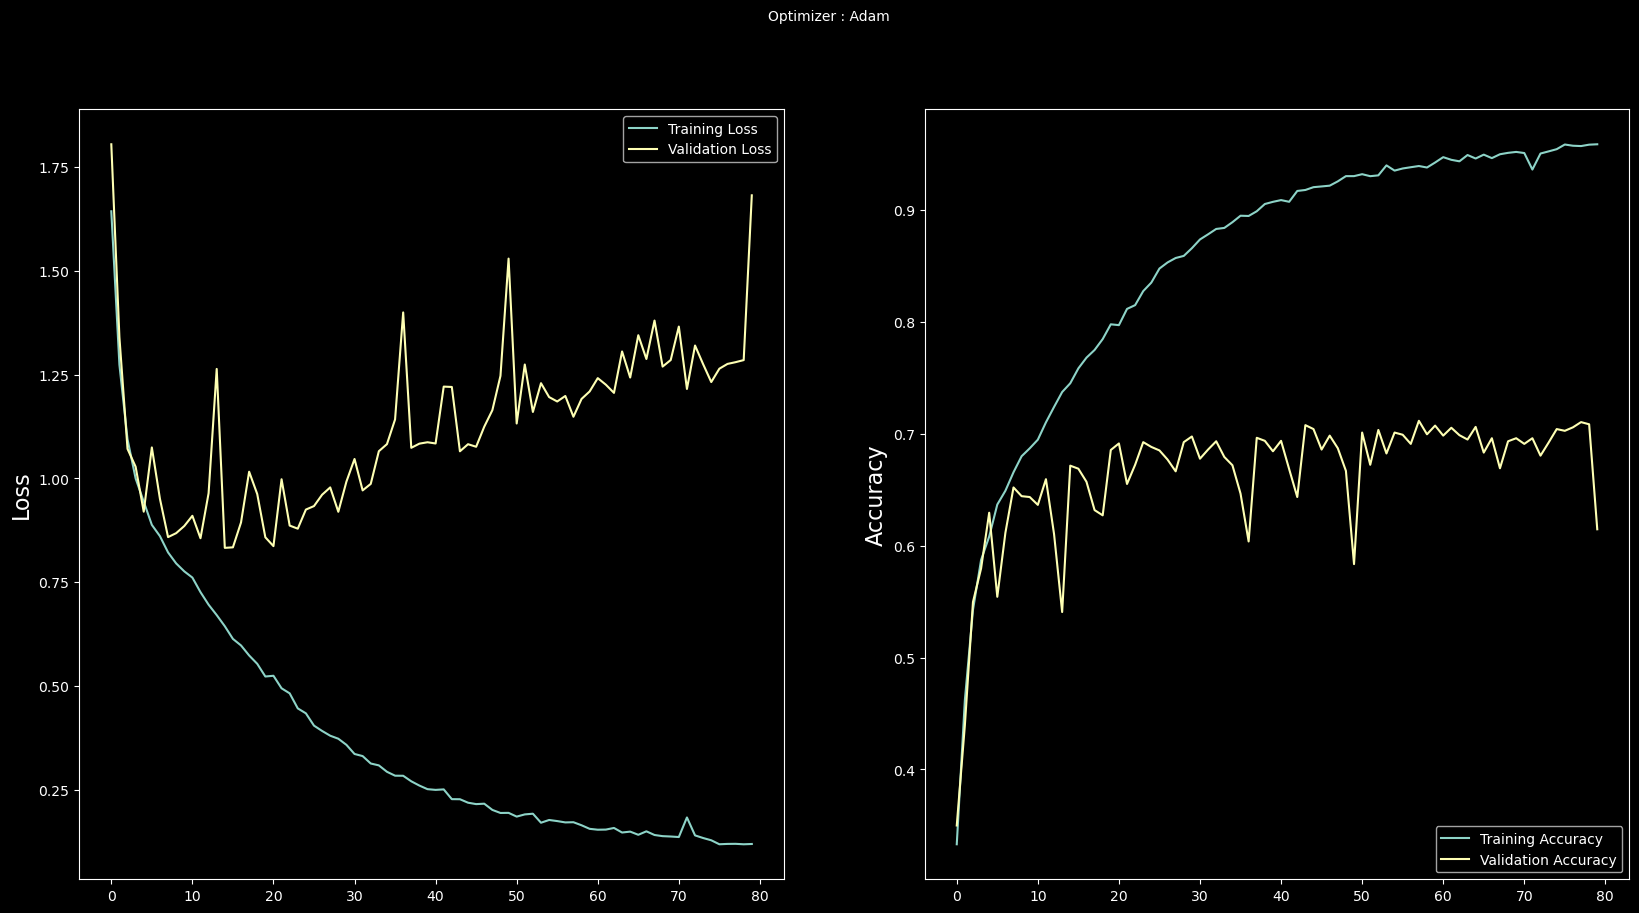

In [18]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()